In [1]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# تابع استخراج ویژگی
# -----------------------
def extract_histogram_features_fixed_resize(image_path, resize_shape=(200, 200), gray_levels=32, grid_size=(10, 10)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, resize_shape)

    patch_h = resize_shape[0] // grid_size[0]
    patch_w = resize_shape[1] // grid_size[1]

    features = []

    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)

    gray_bin_size = 256 // gray_levels
    grad_max = gradient_magnitude.max()
    grad_bin_size = grad_max / gray_levels if grad_max != 0 else 1

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            y1, y2 = i * patch_h, (i + 1) * patch_h
            x1, x2 = j * patch_w, (j + 1) * patch_w

            patch = img[y1:y2, x1:x2]
            grad_patch = gradient_magnitude[y1:y2, x1:x2]

            hist_intensity, _ = np.histogram(patch, bins=gray_levels, range=(0, 256))
            hist_intensity = hist_intensity.astype(np.float32) / (patch.size + 1e-6)

            hist_grad, _ = np.histogram(grad_patch, bins=gray_levels, range=(0, grad_max))
            hist_grad = hist_grad.astype(np.float32) / (grad_patch.size + 1e-6)

            patch_features = np.concatenate([hist_intensity, hist_grad])
            features.append(patch_features)

    return np.concatenate(features)

In [3]:
# لود کردن کل دیتاست
# -----------------------
def load_dataset(dataset_path, labels_dict):
    X, y = [], []
    for label_name, label_index in labels_dict.items():
        folder_path = os.path.join(dataset_path, label_name)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                features = extract_histogram_features_fixed_resize(image_path)
                X.append(features)
                y.append(label_index)
    return np.array(X), np.array(y)


In [4]:
# مسیر و لیبل‌ها
# -----------------------
dataset_path = 'processed_images/'  # مسیر دیتاست کراپ‌شده
labels_dict = {'Tumor': 0, 'Stone': 1, 'Normal': 2, 'Cyst': 3}

In [5]:
# آماده‌سازی داده‌ها
# -----------------------
X, y = load_dataset(dataset_path, labels_dict)


In [7]:

# نرمال‌سازی
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# reshape برای LSTM -> (تعداد نمونه، 100 پنجره، 16 ویژگی)
X_seq = X_scaled.reshape((X_scaled.shape[0], 100, 64))

# تبدیل لیبل به one-hot
y_cat = to_categorical(y, num_classes=4)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_cat, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout, LayerNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical

# تعریف مدل
model = Sequential()

# Bidirectional LSTM (۱)
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(100, 64)))
model.add(LayerNormalization())
model.add(Dropout(0.4))

# Bidirectional LSTM (۲)
model.add(Bidirectional(LSTM(64)))
model.add(LayerNormalization())
model.add(Dropout(0.4))

# Dense لایه fully connected
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# لایه خروجی (۴ کلاس)
model.add(Dense(4, activation='softmax'))

# کامپایل مدل
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model_lstm.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# آموزش مدل
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)



Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5511 - loss: 1.1551
Epoch 1: val_loss improved from inf to 0.64550, saving model to best_model_lstm.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 190ms/step - accuracy: 0.5513 - loss: 1.1545 - val_accuracy: 0.7675 - val_loss: 0.6455 - learning_rate: 5.0000e-04
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7424 - loss: 0.6658
Epoch 2: val_loss improved from 0.64550 to 0.33787, saving model to best_model_lstm.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.7425 - loss: 0.6656 - val_accuracy: 0.8815 - val_loss: 0.3379 - learning_rate: 5.0000e-04
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8139 - loss: 0.4705
Epoch 3: val_loss improved from 0.33787 to 0.27982, saving model to best_model_lstm.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.8139 - loss: 0.4705 - val_accuracy: 0.9052 - val_loss: 0.2798 - learning_rate: 5.0000e-04
Epoch 4/50
312/312 ━━━━━━━

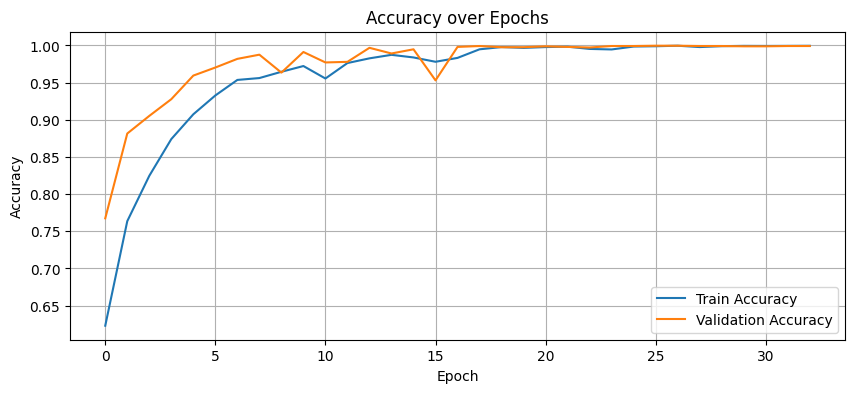

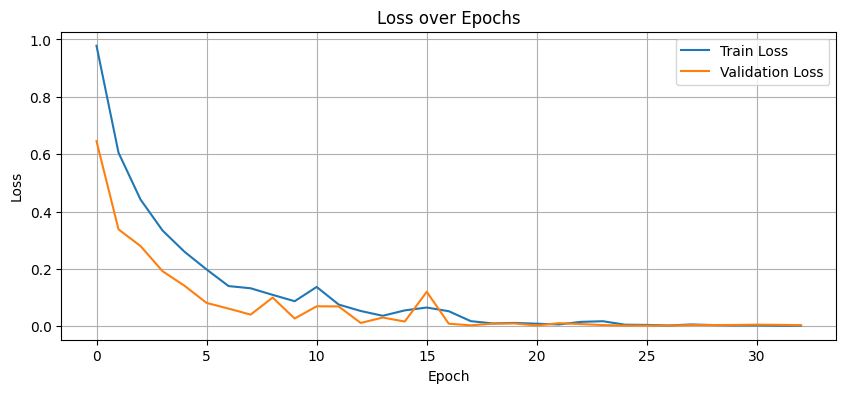

In [10]:
import matplotlib.pyplot as plt

# دقت
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# خطا
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# ارزیابی مدل
# -----------------------
# پیش‌بینی
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# گزارش عملکرد
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Report:\n", classification_report(y_true, y_pred, target_names=labels_dict.keys()))


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
Accuracy: 0.9995983935742971
Confusion Matrix:
 [[ 457    0    0    0]
 [   0  275    0    0]
 [   0    0 1016    0]
 [   1    0    0  741]]
Report:
               precision    recall  f1-score   support

       Tumor       1.00      1.00      1.00       457
       Stone       1.00      1.00      1.00       275
      Normal       1.00      1.00      1.00      1016
        Cyst       1.00      1.00      1.00       742

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



In [12]:
model.save('kidney_ultrasound_lstm_model3.keras')


In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np

# بارگذاری مدل ذخیره شده
model = load_model('best_model_lstm.keras')  # مسیر مدل شما
X = X.reshape(-1, 100, 64)
# پیش‌بینی مدل
y_pred_prob = model.predict(X, batch_size=16)  # خروجی احتمال برای هر کلاس
y_pred = np.argmax(y_pred_prob, axis=1)

# محاسبه دقت
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")


778/778 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step
Accuracy: 0.4984
